In [3]:
sys.path.append('C:/Users/nyasha/Desktop/Masters-Nyasha/Models')

import sys

import torch
import numpy as np
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from DatasetCreator import HAVSDataset

from CAE import *
from training_functions import *

In [1]:
BATCH_SIZE = 128
NUM_EPOCHS = 25

In [4]:
# Extracting the training, validation and testing data
compressed_file_path = "C:/Users/nyasha/Desktop/Masters-Nyasha/Processed Data/processed_data.npz"
x_train, x_test, x_val, y_train, y_test, y_val = get_train_test_data(compressed_file_path)

In [ ]:
# Check if files have been imported correctly
print(x_train.shape)  
print(x_test.shape)
print(x_val.shape)
print(y_train.shape) 
print(y_test.shape)
print(y_val.shape)

In [12]:
# Check if type is correct
print(type(x_train))  
print(type(x_test))
print(type(x_val))
print(type(y_train)) 
print(type(y_test))
print(type(y_val))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [5]:
# Define the transforms
transform = transforms.Compose(
    [
     transforms.ToTensor()
    ])

In [6]:
# Create the datasets
train_dataset = HAVSDataset(x_train, y_train, transform=transform)
val_dataset = HAVSDataset(x_val, y_val, transform=transform)
test_dataset = HAVSDataset(x_test, y_test, transform=transform)

In [7]:
# Creating the data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        ## encoder layers ##

        self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) 
    
        self.conv2 = nn.Conv2d(32, 16, 3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        # add second hidden layer
        """"
        x = F.relu(self.conv2(x))
        x = self.pool2(x)  # compressed representation
        """

        return x

class Decoder(nn.Module):
    def __init__(self):

        super(Decoder, self).__init__()
        self.dconv1 = nn.ConvTranspose2d(16, 32, 3, padding=1, stride=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
        
        self.dconv2 = nn.ConvTranspose2d(32, 1, 3, padding=1, stride=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, encode):
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.dconv1(encode))
        x = self.upsample1(x)

        x = F.relu(self.dconv2(x))
        x = self.upsample2(x)
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(x)

        return x

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, img):
        x = self.encoder(img)
        x = self.decoder(x)
        
        return x



In [70]:
# Select a model from ../Models
model_1  = CAE_3()
print(model_1)

CAE_3(
  (encoder): Encoder_3(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Decoder_3(
    (deconv3): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (deconv2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (deconv1): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [71]:
# Get number of parameters
pytorch_total_params_model_1 = sum(p.numel() for p in model_1.parameters())
print(f"The number of  parameters in this model is {pytorch_total_params_model_1}")

The number of  parameters in this model is 3913


In [72]:
device = get_device() 
model_on_device = model_1.to(device) # Move model to the current device

Running on the GPU


In [73]:
# Specify loss function
criterion = nn.BCELoss()

# Specify optimizer
optimizer = torch.optim.SGD(model_on_device.parameters(), lr=0.01)

In [74]:
criterion._get_name()

'BCELoss'

In [66]:
str(optimizer)

'SGD (\nParameter Group 0\n    dampening: 0\n    lr: 0.01\n    momentum: 0\n    nesterov: False\n    weight_decay: 0\n)'

In [75]:
# Train the CAE reconstruction model
train_cae(100, train_loader, criterion, optimizer, device, model_on_device)


C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
Epoch: 1 	Training Loss: 89.397589
Epoch: 2 	Training Loss: 87.668517
Epoch: 3 	Training Loss: 87.510886
Epoch: 4 	Training Loss: 87.434840
Epoch: 5 	Training Loss: 87.388739
Epoch: 6 	Training Loss: 87.356326
Epoch: 7 	Training Loss: 87.332818
Epoch: 8 	Training Loss: 87.314880
Epoch: 9 	Training Loss: 87.301413
Epoch: 10 	Training Loss: 87.289440
Epoch: 11 	Training Loss: 87.280489
Epoch: 12 	Training Loss: 87.272513
Epoch: 13 	Training Loss: 87.265723
Epoch: 14 	Training Loss: 87.259962
Epoch: 15 	Training Loss: 87.254724
Epoch: 16 	Training Loss: 87.250455
Epoch: 17 	Training Loss: 87.246539
Epoch: 18 	Traini

In [85]:
torch.save(model_on_device, "model.pth")
# model_on_device = torch.load("model.pth")

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
Original Images


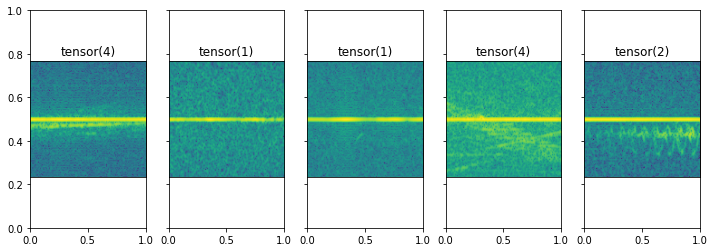

Reconstructed Images


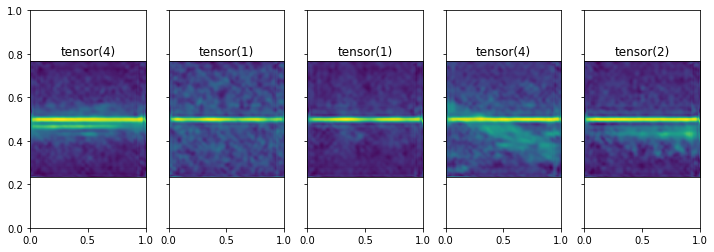

In [84]:
# Visualize CAE model performance,
visualise_cae_performance(train_loader, device, model_on_device, 128, 128, 128)

In [86]:
model_on_device

CAE_3(
  (encoder): Encoder_3(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Decoder_3(
    (deconv3): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (deconv2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (deconv1): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [87]:
# Freeze model weights
for param in model_on_device.parameters():
    param.requires_grad = False

In [88]:
class Flatten(nn.Module):
    """Flattening CNN output"""
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

In [89]:
# Remove transpose layer

dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device, dtype=torch.float)
net2 = nn.Sequential(*list(model_on_device.children())[:-1])
net2.eval() # Switch to evaluation mode
net2(images).shape
net2.add_module('flatten', Flatten())
dense_in = net2(images.cuda()).shape[1] # Get the dense layer shape


In [90]:
dense_in

8192

In [91]:
# Replace the model's decoder with dense layer
model_on_device.decoder = nn.Sequential(
    Flatten(),
    nn.Linear(dense_in, 6),
    nn.ReLU(),
    nn.Softmax(dim=1)
)

In [92]:
model_on_device = model_on_device.to(device)

In [93]:
class_weights = get_class_weights(y_train, device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model_on_device.parameters(), lr=0.01)

C:\Users\nyasha\anaconda3\envs\masters\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['2_walking' 'clutter/noise' 'running' 'sphere_swing' 'vehicle' 'walking'], y=['walking' 'walking' 'vehicle' ... 'running' 'clutter/noise' 'vehicle'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [94]:
# Train the classification model
train_model(50
, train_loader, val_loader, criterion, optimizer, device, model_on_device)

Evaluating performance on validation data
Accuracy of the network on the test images: 39 %
Epoch: 1/50 	 Training Loss: 2.3678, Accuracy: 36.38, Testing Loss: 1.6154, Accuracy: 39.37
Evaluating performance on validation data
Accuracy of the network on the test images: 47 %
Epoch: 2/50 	 Training Loss: 2.2390, Accuracy: 46.36, Testing Loss: 1.5575, Accuracy: 47.10
Evaluating performance on validation data
Accuracy of the network on the test images: 45 %
Epoch: 3/50 	 Training Loss: 2.2004, Accuracy: 47.91, Testing Loss: 1.5495, Accuracy: 45.28
Evaluating performance on validation data
Accuracy of the network on the test images: 48 %
Epoch: 4/50 	 Training Loss: 2.1883, Accuracy: 48.99, Testing Loss: 1.5327, Accuracy: 48.30
Evaluating performance on validation data
Accuracy of the network on the test images: 48 %
Epoch: 5/50 	 Training Loss: 2.1726, Accuracy: 49.74, Testing Loss: 1.5305, Accuracy: 48.78
Evaluating performance on validation data
Accuracy of the network on the test images:

In [95]:
# Evaluate model performance on test data
evaluate_model(test_loader, device, model_on_device, criterion)

Accuracy of the network on the test images: 55 %


(1.4630657070774142, 55.52730192719486)